# Projet Analyse de Données : Stratège virtuel de Formule 1

<b>Ce projet porte sur l'étude et l'analyse des résultats et de données de toutes les courses de Formule 1 qui se sont déroulées de 1950 à 2018.</b><br><br>
En Formule 1, de nombreux facteurs sont clés dans la route vers la victoire d'un Grand Prix. On retrouve entre autres : 
<ul>
    <li>La performance de la voiture</li>
    <li>Le talent du pilote</li>
    <li>La position sur la grille (déterminée par une séance de qualification)</li>
    <li>La gestion de l'essence</li>
    <li>La gestion de l'usure des pneus et l'utilisation astucieuse d'arrêts au stand</li>
    <li>La réactivité aux évènements de course comme la tombée de pluie, les accidents sur piste...</li>
</ul>

Dans ce projet, nous allons, entre autres, tenter de prédire la position à l'arrivée d'un pilote, ou bien essayer de déterminer à quel moment de la course un pilote a réalisé un arrêt au stand.<br><br>


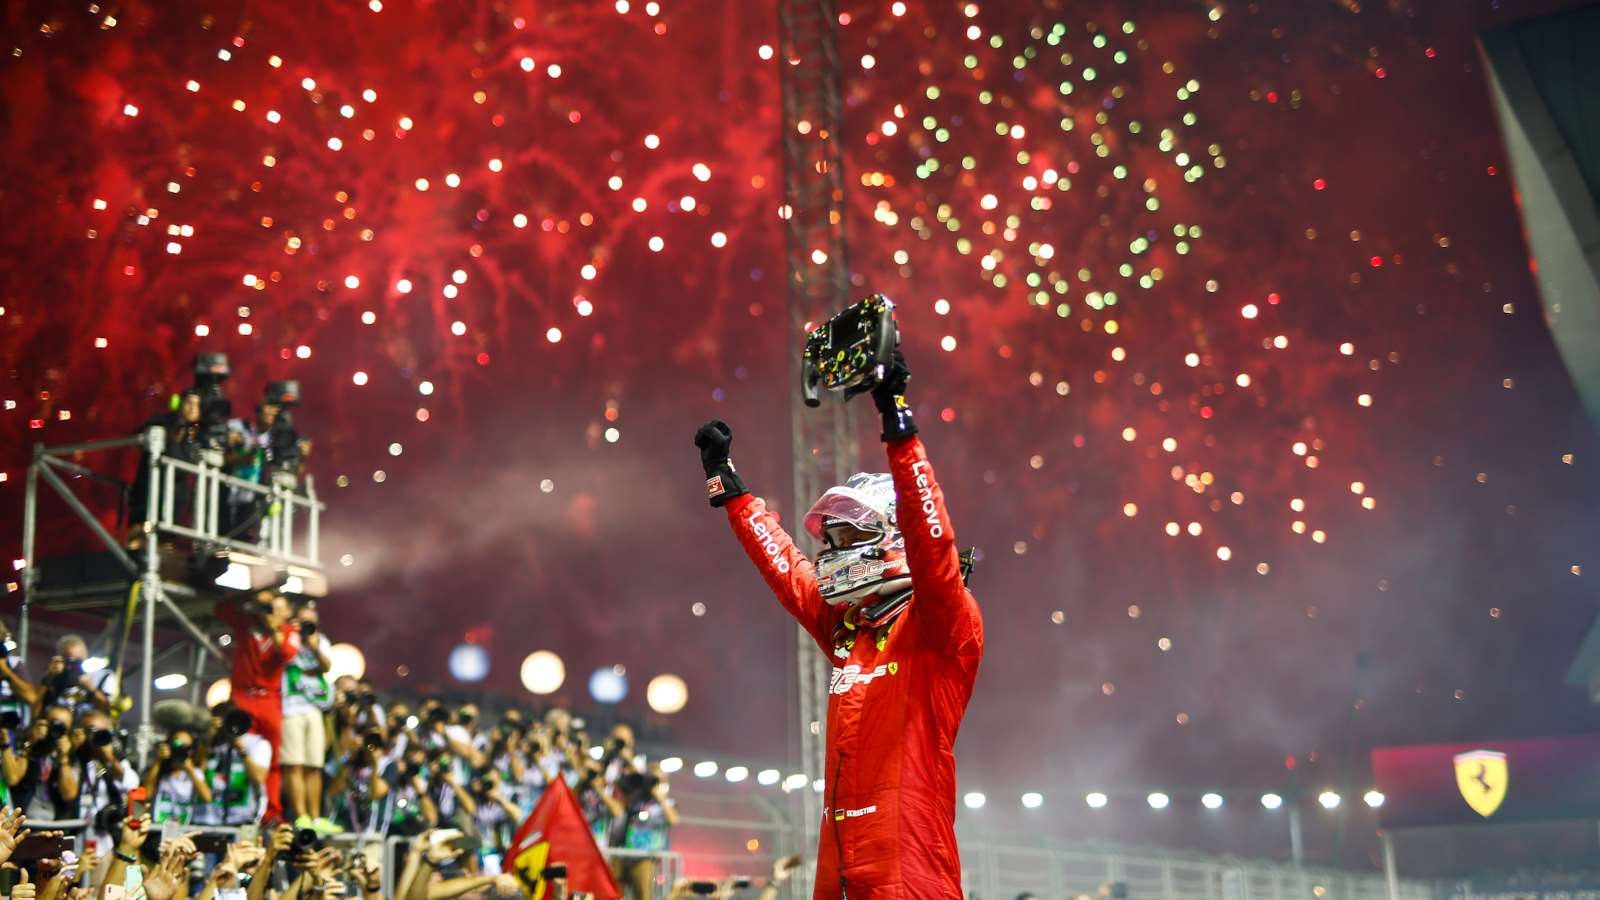


On importe les librairies utiles pour ce projet.

In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scikitplot as skplt

sns.set()
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

On importe le dataset

In [ ]:
circuits = pd.read_csv("circuits.csv", index_col=0)
constructorResults = pd.read_csv("constructorResults.csv", index_col=0)
constructors = pd.read_csv("constructors.csv", index_col=0)
constructorStandings = pd.read_csv("constructorStandings.csv", index_col=0)
drivers = pd.read_csv("drivers.csv", index_col=0)
lapTimes = pd.read_csv("lapTimes.csv")
pitStops = pd.read_csv("pitStops.csv")
qualifying = pd.read_csv("qualifying.csv", index_col=0)
races = pd.read_csv("races.csv",index_col=0)
results = pd.read_csv("results.csv", index_col=0)
status = pd.read_csv("status.csv", index_col=0)
races = races.reindex(np.random.permutation(races.index))

## Nettoyage des datasets
Ici, nous allons supprimer les colonnes qui ne nous intéressent pas et qui prennent une place inutile à l'affichage.<br>

In [ ]:
drivers = drivers.drop(columns='url')
circuits = circuits.drop(columns=['alt','url','lat','lng','location'])
constructorResults = constructorResults.drop(columns='status')
constructors = constructors.drop(columns=['url','Unnamed: 5'])
constructorStandings = constructorStandings.drop(columns='Unnamed: 7')
races = races.drop(columns=['url','time'])
# races.index.name = 'raceId'

In [ ]:
display(races.iloc[840])
display(races.head(20))

## Création de quelques fonctions utiles

In [ ]:
def getDriverName(driverId):
    try:
        name = str(drivers['forename'].loc[driverId])+' '+str(drivers['surname'].loc[driverId])
        return name
    except UnicodeDecodeError:
        return driverRef

def getDriverId(forename, surname):
    return drivers.index[(drivers['forename'] == forename) & (drivers['surname'] == surname)].tolist()[0]

def getConstructorId(constructor):
    return constructors.index[constructors['name'] == constructor].tolist()[0]

def getConstructorName(id):
    return str(constructors['name'].loc[id])

print('Le constructorId de Red Bull Racing est {}'.format(getConstructorId('Red Bull')))
print('Le driverId de Max Verstappen est {}'.format(getDriverId('Max','Verstappen')))
print("L'équipe ayant le constructorId 21 est {}".format(getConstructorName(21)))

In [ ]:
def getWCCPoints(year,constructorId):
    try:
        myRaces = races[races['year'] == year].sort_values('round')
        standings = constructorStandings[constructorStandings['constructorId'] == constructorId]
        standings = standings.merge(myRaces,right_index=True,left_on='raceId')
        return standings['points'].iloc[standings.shape[0]-1]
    except Exception:
        print('Impossible de retrouver les points')

def getWCCResult(year, constructorId):
    try:
        myRaces = races[races['year'] == year].sort_values('round')
        standings = constructorStandings.merge(myRaces,right_index=True,left_on='raceId')
        standings = standings[standings['round'] == standings['round'].max()]
        standings = standings[standings['constructorId'] == constructorId]
    #     print("L'équipe "+getConstructorName(constructorId)+'('+str(constructorId)+')'+" a terminé "+str(standings['position'].tolist()[0])+"e")
        return standings['position'].tolist()[0]
    except Exception:
        return 5
    
def getWCCPosition(year, myround, constructorId):
    try:
        myRaces = races[races['year'] == year].sort_values('round')
        standings = constructorStandings.merge(myRaces,right_index=True,left_on='raceId')
        standings = standings[standings['round'] == myround]
        standings = standings[standings['constructorId'] == constructorId]
        return standings['position'].tolist()[0]
    except Exception:
        return 5
    
    
def getWCCStandings(year):
    myRaces = races[races['year'] == year].sort_values('round')
    standings = constructorStandings.merge(myRaces,right_index=True,left_on='raceId')
    standings = standings[standings['round'] == standings['round'].max()]
    return standings[['constructorId','position']].sort_values('position',ascending=True)

def printQualifying(race):
    i=1
    while i < race['grid'].max():
        try:
            print("=========={}==========\n {}           =========={}==========\n                          {}\n".format(i, getDriverName(race['driverId'].iloc[i]),i+1,getDriverName(race['driverId'].iloc[i+1])))
            i+=2
        except Exception:
            i+=1
    

In [ ]:
def getInformation(raceId, driverId):
    try:
        race = races.loc[raceId] #Find the race
        driver = drivers.loc[driverId] #Find the driver
        result = results[(results['raceId'] == raceId) & (results['driverId'] == driverId)].iloc[0]
        pits = pitStops[(pitStops['raceId'] == raceId) & (pitStops['driverId'] == driverId)]
        quali = qualifying[(qualifying['raceId'] == raceId) & (qualifying['driverId'] == driverId)]
        laps = lapTimes[(lapTimes['raceId'] == raceId) & (lapTimes['driverId'] == driverId)]
        return(race,driver,result,pits,quali,laps)
    except Exception:
        print('Impossible de trouver la course n°{}'.format(raceId))
        return getInformation(raceId-1,driverId)

def getRaceInformation(raceId):
    try:
        race = races.loc[raceId]
        result = results[results['raceId'] == raceId]
        winner = result[result['positionOrder'] == 1]['driverId'].iloc[0]
        print(str(race['year'])+ ' '+str(race['name'])+'\n')
        print('Le vainqueur de la course est : '+getDriverName(winner))
        print('Le podium est composé de :')
        for i in range(0,3):
            print(str(getDriverName(result['driverId'].iloc[i]))+' ('+str(result['driverId'].iloc[i])+') ')
        print('')
    except Exception:
        print('Impossible de trouver la course n°{}'.format(raceId))
        return getRaceInformation(raceId-1)

def getQualifyingPosition(raceId, driverId):
    quali = getInformation(raceId,driverId)[4]
    if not quali.empty:
        return quali['position'].iloc[0]
    else :
        return 'Inconnu'

def getRaceReport(raceId, driverId):
    (race,driver,result,pits,quali,laps) = getInformation(raceId,driverId)
    print('{} {} (raceId : {})\n'.format(race['year'],race['name'],race.index.name))
    print('Résumé de course de '+str(driver['forename'])+' '+str(driver['surname'])+'\n')
    print('Résultat de qualification : '+str(getQualifyingPosition(raceId,driverId)))
    print('Position sur la grille de départ : '+str(result['grid'])+'\n')
    print('Position finale : '+str(result['positionText']))
    print('Pit-stops effectués par le pilote : '+str(pits.shape[0]))
    if not pits.empty:   
        display(pits[['lap','duration']])
    if not laps.empty:
        fig = plt.figure(figsize=(8,6))
        ax1 = fig.add_subplot(111)
        plt.fill_between(laps['lap'], laps['position'],color="gold", alpha=0.5)
        ax1.plot(laps['lap'].tolist(), laps['position'].tolist(),color='yellow')
        ax1.set_ylabel('position')
        ax1.set_facecolor('xkcd:white')
        ax2 = ax1.twinx()
        ax2.plot(laps['lap'].tolist(), laps['milliseconds'].tolist(), 'blue')
        ax2.set_ylabel('milliseconds',color='blue')
        ax1.grid(False)
        ax2.grid(False)

def getComparison(raceId,driver1,driver2):
    (race,driver,result,pits,quali,laps) =getInformation(raceId,driver1)
    (race2,driver2,result2,pits2,quali2,laps2) =getInformation(raceId,driver2)
    if not laps.empty and not laps2.empty:
        fig = plt.figure(figsize=(14,5),dpi=300)
        ax2 = fig.add_subplot(121)
        l1, = ax2.plot(laps['lap'].tolist(), laps['milliseconds'].tolist(), 'blue')
        l2, = ax2.plot(laps2['lap'].tolist(), laps2['milliseconds'].tolist(), 'red')
        ax2.set_ylabel('milliseconds')
        l1.set_label(getDriverName(driver1))
        l2.set_label(getDriverName(driver2.name))
        ax2.legend()
        ax2.title.set_text('Comparaison des temps au tour')
        
        ax1 = fig.add_subplot(122)
        ax1.set_ylabel('position')
        plt.gca().invert_yaxis()
#         plt.fill_between(laps['lap'], laps['position'],color="blue", alpha=0.1)
#         plt.fill_between(laps2['lap'], laps2['position'],color="red", alpha=0.1)
        l3, = ax1.plot(laps['lap'].tolist(), laps['position'].tolist(),color='blue')
        l3.set_label(getDriverName(driver1))
        l4, = ax1.plot(laps2['lap'].tolist(), laps2['position'].tolist(),color='red')
        l4.set_label(getDriverName(driver2.name))
        ax1.legend()
        ax1.title.set_text('Comparaison de la position')
        plt.tight_layout()
    else:
        print('Comparaison non disponible')

# getRaceInformation(840)
getRaceReport(988,830)
getComparison(988,1,830)

## Prédiction du vainqueur d'un Grand Prix

Si vous aimez les histoires d'<i>outsiders</i>, la Formule 1 n'est peut-être pas le sport pour vous.<br>
Dans la catégorie reine du sport automobile, injuste pour certains, les mêmes écuries ont tendance à dominer le plateau pendant une saison entière, voire même plusieurs : il suffit d'examiner la domination de Michael Schumacher avec Ferrari en 2000-2004 ou bien celle de Lewis Hamilton avec Mercedes en 2014-2019 pour s'en rendre compte.

La position à laquelle un pilote commence la course est préalablement déterminée par une séance de qualifications, dans laquelle la voiture la plus puissante est plus susceptible d'obtenir la <i>pole position</i> que les écuries confinées au fond du plateau.

Dans ce contexte, on peut essayer de prédire la position à l'arrivée d'un pilote, en se basant sur plusieurs caractéristiques comme son résultat de qualifications ou bien la puissance de sa voiture.

Dans cette section, nous allons nous intéresser à ce problème de régression.

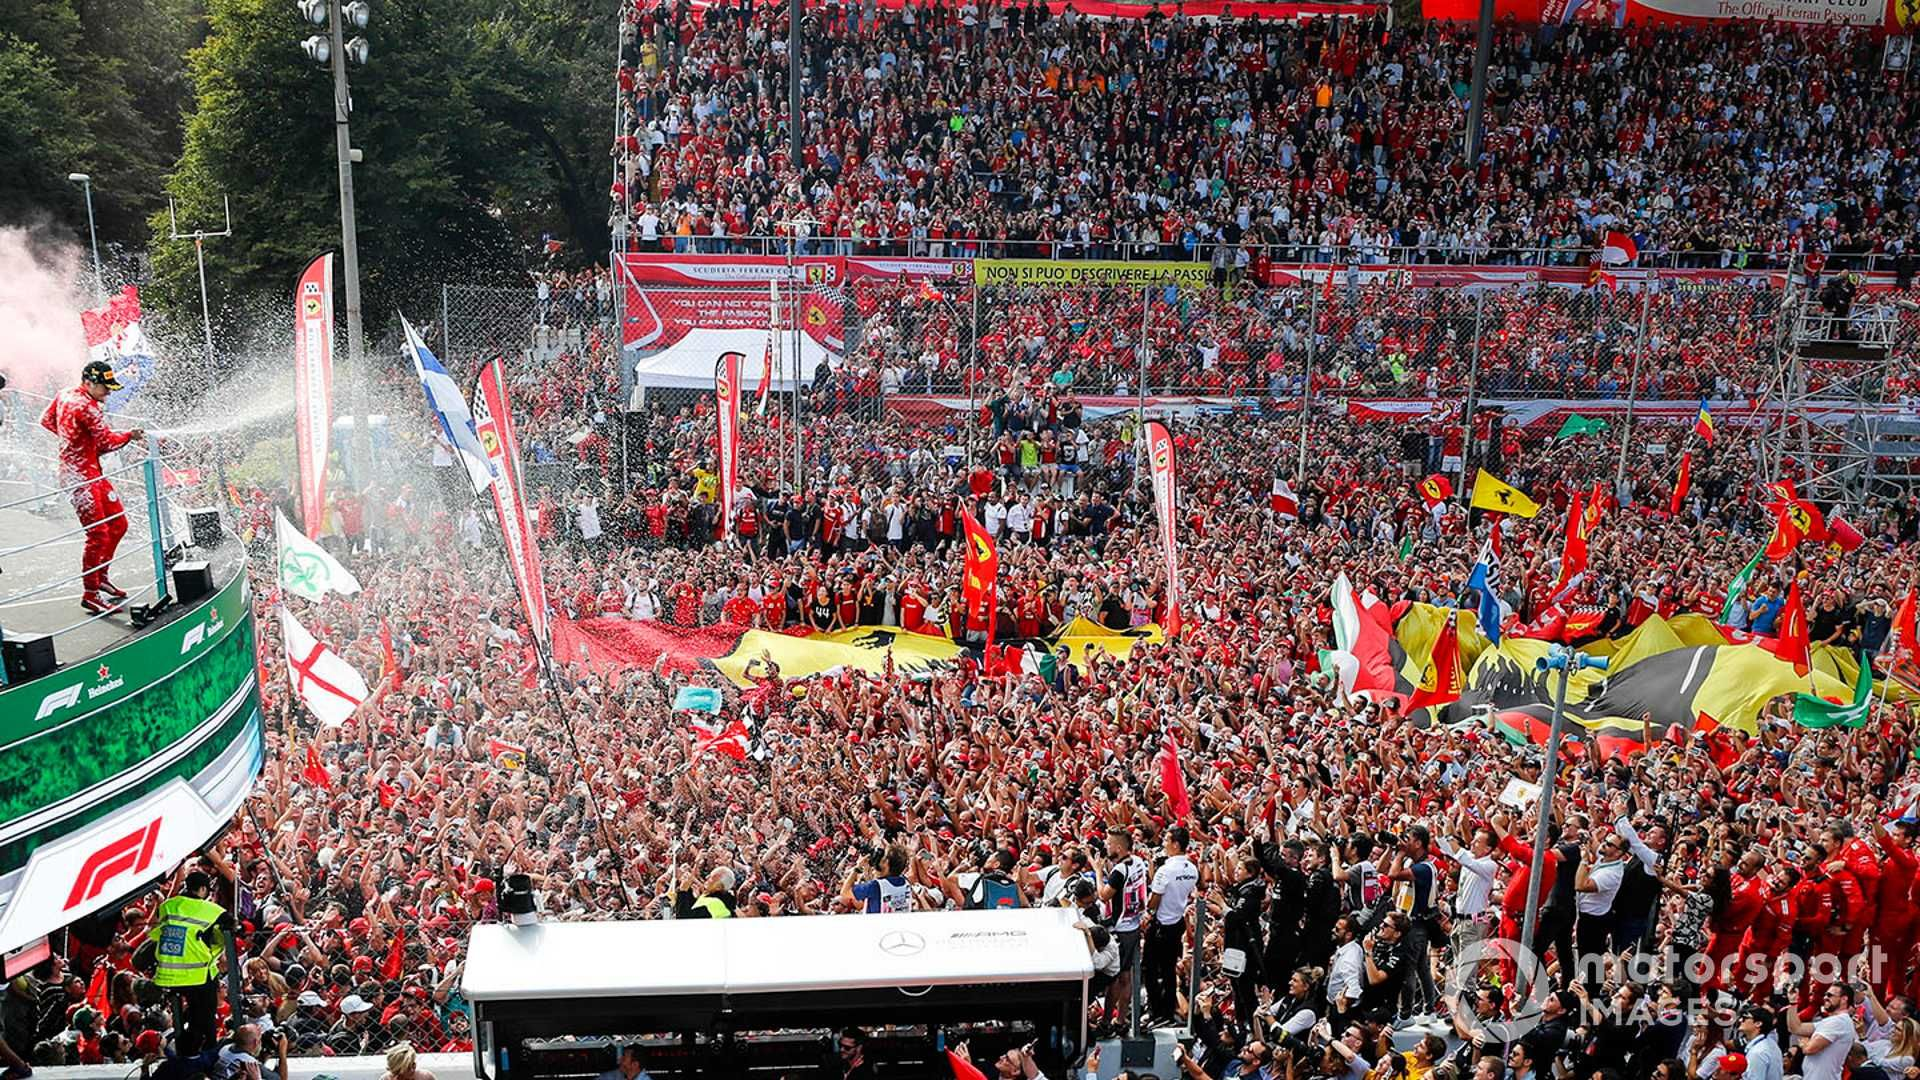

Le dataset ne nous fournit pas la puissance de la voiture, cette donnée n'étant pas quantifiable (mis à part peut-être la puissance du moteur). Nous devons donc essayer nous-même de quantifier ce paramètre.

Dans le paddock, les deux ou trois écuries dominatrices arrivent à réaliser des tours souvent plus d'une seconde plus rapide que les écuries de milieu de plateau et les <i>backrunners</i> : on cherche donc un coefficient $\mu_x$ permettant de modéliser cette disparité. Nous choisirons $\mu_x = \frac{1}{tan(0.1x)^{0.7}}$, avec $x$ la position au championnat constructeurs de l'année précédente.

In [ ]:
def prepareDataset(raceId):
    '''
    Cette fonction renvoie, pour une course, les résultats de cette course agrémentés des coefficients.
    '''
    result = results[results['raceId'] == raceId]
    year = races['year'].loc[raceId]
    current_round = races['round'].loc[raceId]
    result['constructorPower'] = result['constructorId'].apply(lambda x: 1.0/np.power(np.tan(0.1*getWCCResult(year-1,x)),0.7))
    result['constructorForm'] = result['constructorId'].apply(lambda x: 1.0/np.power(np.tan(0.1*getWCCPosition(year,current_round,x)),0.7))
    result = result[['driverId','constructorId','grid','positionOrder','points','statusId','constructorPower','constructorForm']].sort_values('grid')
    return result

In [ ]:
my_dataset = prepareDataset(1)
print(races.shape[0])
for i in range(2, races.shape[0]/0):
    print("{}/{}\r".format(i,races.shape[0]/20)),
    my_dataset = my_dataset.append(prepareDataset(i))
    
display(my_dataset)

In [ ]:
my_dataset.describe()
my_dataset = my_dataset[(my_dataset['statusId'] == 1) | (my_dataset['statusId'] == 11) | (my_dataset['statusId'] == 12)]
my_dataset = my_dataset[['grid','positionOrder','constructorPower','constructorForm']]


In [ ]:
my_dataset = my_dataset.reindex(np.random.permutation(my_dataset.index))
display(my_dataset.head(40))


In [ ]:
# my_dataset.plot(x='grid', y='positionOrder', style='o')  
# plt.title('MinTemp vs MaxTemp')  
# plt.xlabel('Constructor Power')  
# plt.ylabel('Grid position')  
# plt.show()

sns.jointplot(my_dataset['grid'],my_dataset['positionOrder'],
              kind='hex')
plt.suptitle("Position a l'arrivee en fonction de la position de depart")

sns.jointplot(my_dataset['constructorPower'],my_dataset['positionOrder'],
              kind='hex')
plt.suptitle("Position a l'arrivee en fonction de la position au championnat n-1")

sns.jointplot(my_dataset['constructorForm'],my_dataset['positionOrder'],
              kind='hex')
plt.suptitle("Position a l'arrivee en fonction de la position au championnat")

In [ ]:
my_dataset = my_dataset.dropna()

train_dataset = my_dataset.sample(frac=0.8,random_state=1)
test_dataset = my_dataset.drop(train_dataset.index)

train_stats = train_dataset.describe()
train_stats.pop("positionOrder")
train_stats = train_stats.transpose()

train_labels = train_dataset.pop('positionOrder')
test_labels = test_dataset.pop('positionOrder')

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

display(normed_test_data.head(20))

### Création du modèle avec TensorFlow

Typiquement, TensorFlow permet d'obtenir une bonne précision sur les résultats si on sait ce qu'on fait.
Nous allons créer et entraîner un modèle TensorFlow puis comparer ses prédictions avec notre propre modèle.

In [ ]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model
model = build_model()

In [ ]:
EPOCHS = 100

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=1)
test_predictions = model.predict(normed_test_data).flatten()


In [ ]:
sns.jointplot(test_labels, test_predictions, kind='hex')
plt.suptitle('Valeurs predites par TensorFlow contre vraies valeurs')

In [ ]:
TFError = test_predictions - test_labels
fig, ax = plt.subplots(1,1)
plt.hist(TFError, bins = 20, color='gold',alpha=0.9)
ax.set_facecolor('xkcd:dark grey')
ax.grid(False)

plt.xlabel("Erreur sur la prediction avec TensorFlow")
_ = plt.ylabel("Nombre")

### Création du modèle à la mano

Ici, nous allons coder à la main une fonction de descente de gradient dans le but de créer un modèle de régression linéaire pour prédire la position à l'arrivée d'un pilote.
L'objectif est de pouvoir faire tourner l'algorithme plus rapidement que Lance Stroll.

In [ ]:

def loss(predicted_labels,labels):
    '''
    Cette fonction de perte renvoie la MSE (Mean Square Error)
    '''
    m = len(labels)
    mySum = 0
    for i in range(0,len(labels)-1):
        mySum += np.power((predicted_labels[i]-labels[i]),2)
    mySum = (1.0/m)*mySum
    return np.sqrt(mySum)


def gradient_descent(data,weights,labels,speed=0.05,niter=100,tol=0.00001,i=0):
    '''
    Weights est un vecteur n colonnes, data est une matrice m lignes n colonnes, les prédictions sont un vecteur m colonnes
    '''
    prediction = np.dot(data,weights)
    coeff = (1.0*speed)/data.shape[0]
    lossIter = loss(prediction,labels)
    for j in range(0,(weights.shape[0])):
        time.sleep(0.01)
        myLoss = 0
        for k in range(0,data.shape[0]):
            myLoss += (prediction[k]-labels[k])*data[k][j]
        print('Itération {}, weights[0] = {}, weights[1] = {}, le cout est de {}\r'.format(i,weights[0],weights[1],myLoss)),
        weights[j] = (weights[j]-(1.0*coeff*myLoss))
    if lossIter < tol or i >= niter:
        return weights
    hist.append(lossIter)
    return gradient_descent(data,weights,labels,speed,niter,tol,i+1)

def predict(data,weights):
    return np.dot(data,weights)

hist = []
train = train_dataset.to_numpy()
lab = train_labels.to_numpy()
test = test_dataset.to_numpy()
test_lab = test_labels.to_numpy()
print(train.shape[1])
my_weights = gradient_descent(train,np.random.rand(train.shape[1]),lab,speed=0.005, niter=150)
my_test = predict(test,my_weights)

In [ ]:
fig = plt.figure(figsize=(8,6))
ax3 = fig.add_subplot(111)
l1, = ax3.plot(np.arange(len(hist)), hist, 'red')
plt.suptitle('Evolution de la RMSE en fonction des iterations')
# plt.yscale('log')

In [ ]:
myplot = sns.jointplot(my_test, test_lab,kind='hex')
plt.suptitle("Valeurs predites contre vraies valeurs")

In [ ]:
error = my_test - test_lab
fig, ax = plt.subplots(1,1)
plt.hist(error, bins = 20, color='gold',alpha=0.9)
ax.set_facecolor('xkcd:dark grey')
ax.grid(False)
plt.xlabel("Erreur sur la prediction")
_ = plt.ylabel("Nombre")

On peut remarquer que l'algorithme de descente de gradient ne présente pas d'overfitting et prédit plutôt bien la position d'arrivée du pilote, même si l'algorithme de TensorFlow est légèrement plus performant.

In [ ]:
fig = plt.figure(figsize=(14,5),dpi=300)
ax2 = fig.add_subplot(121)
ax2.hist(error, bins = 20, color='blue',alpha=0.5)
ax2.set_ylabel('Nombre de predictions')
ax2.set_xlabel('Erreur (en nombre de positions)')
ax2.set_facecolor('xkcd:white')
plt.xlim(-10,10)
ax2.legend()
ax2.grid(False)
ax2.title.set_text('Descente de gradient')
     
ax1 = fig.add_subplot(122)
ax1.hist(TFError, bins = 20, color='red',alpha=0.5)
ax1.title.set_text('TensorFlow')
ax1.set_facecolor('xkcd:white')
plt.xlim(-10,10)
ax1.set_xlabel('Erreur (en nombre de positions)')
ax1.grid(False)
plt.tight_layout()

## Remplissage du dataset des pit-stops

Le dataset que nous utilisons est incomplet : en effet, il ne propose les informations de pit-stop qu'à partir de la 841e course, alors que les données des temps au tour sont disponibles pour beaucoup plus de courses. Nous souhaitons remplir ce dataset.

On remarque qu'un pit-stop est symbolisé sur le graphique des temps au tour par un pic brusque entre deux tours rapides. Il est donc possible d'utiliser un algorithme d'apprentissage supervisé pour trouver les pit-stops à chaque course.

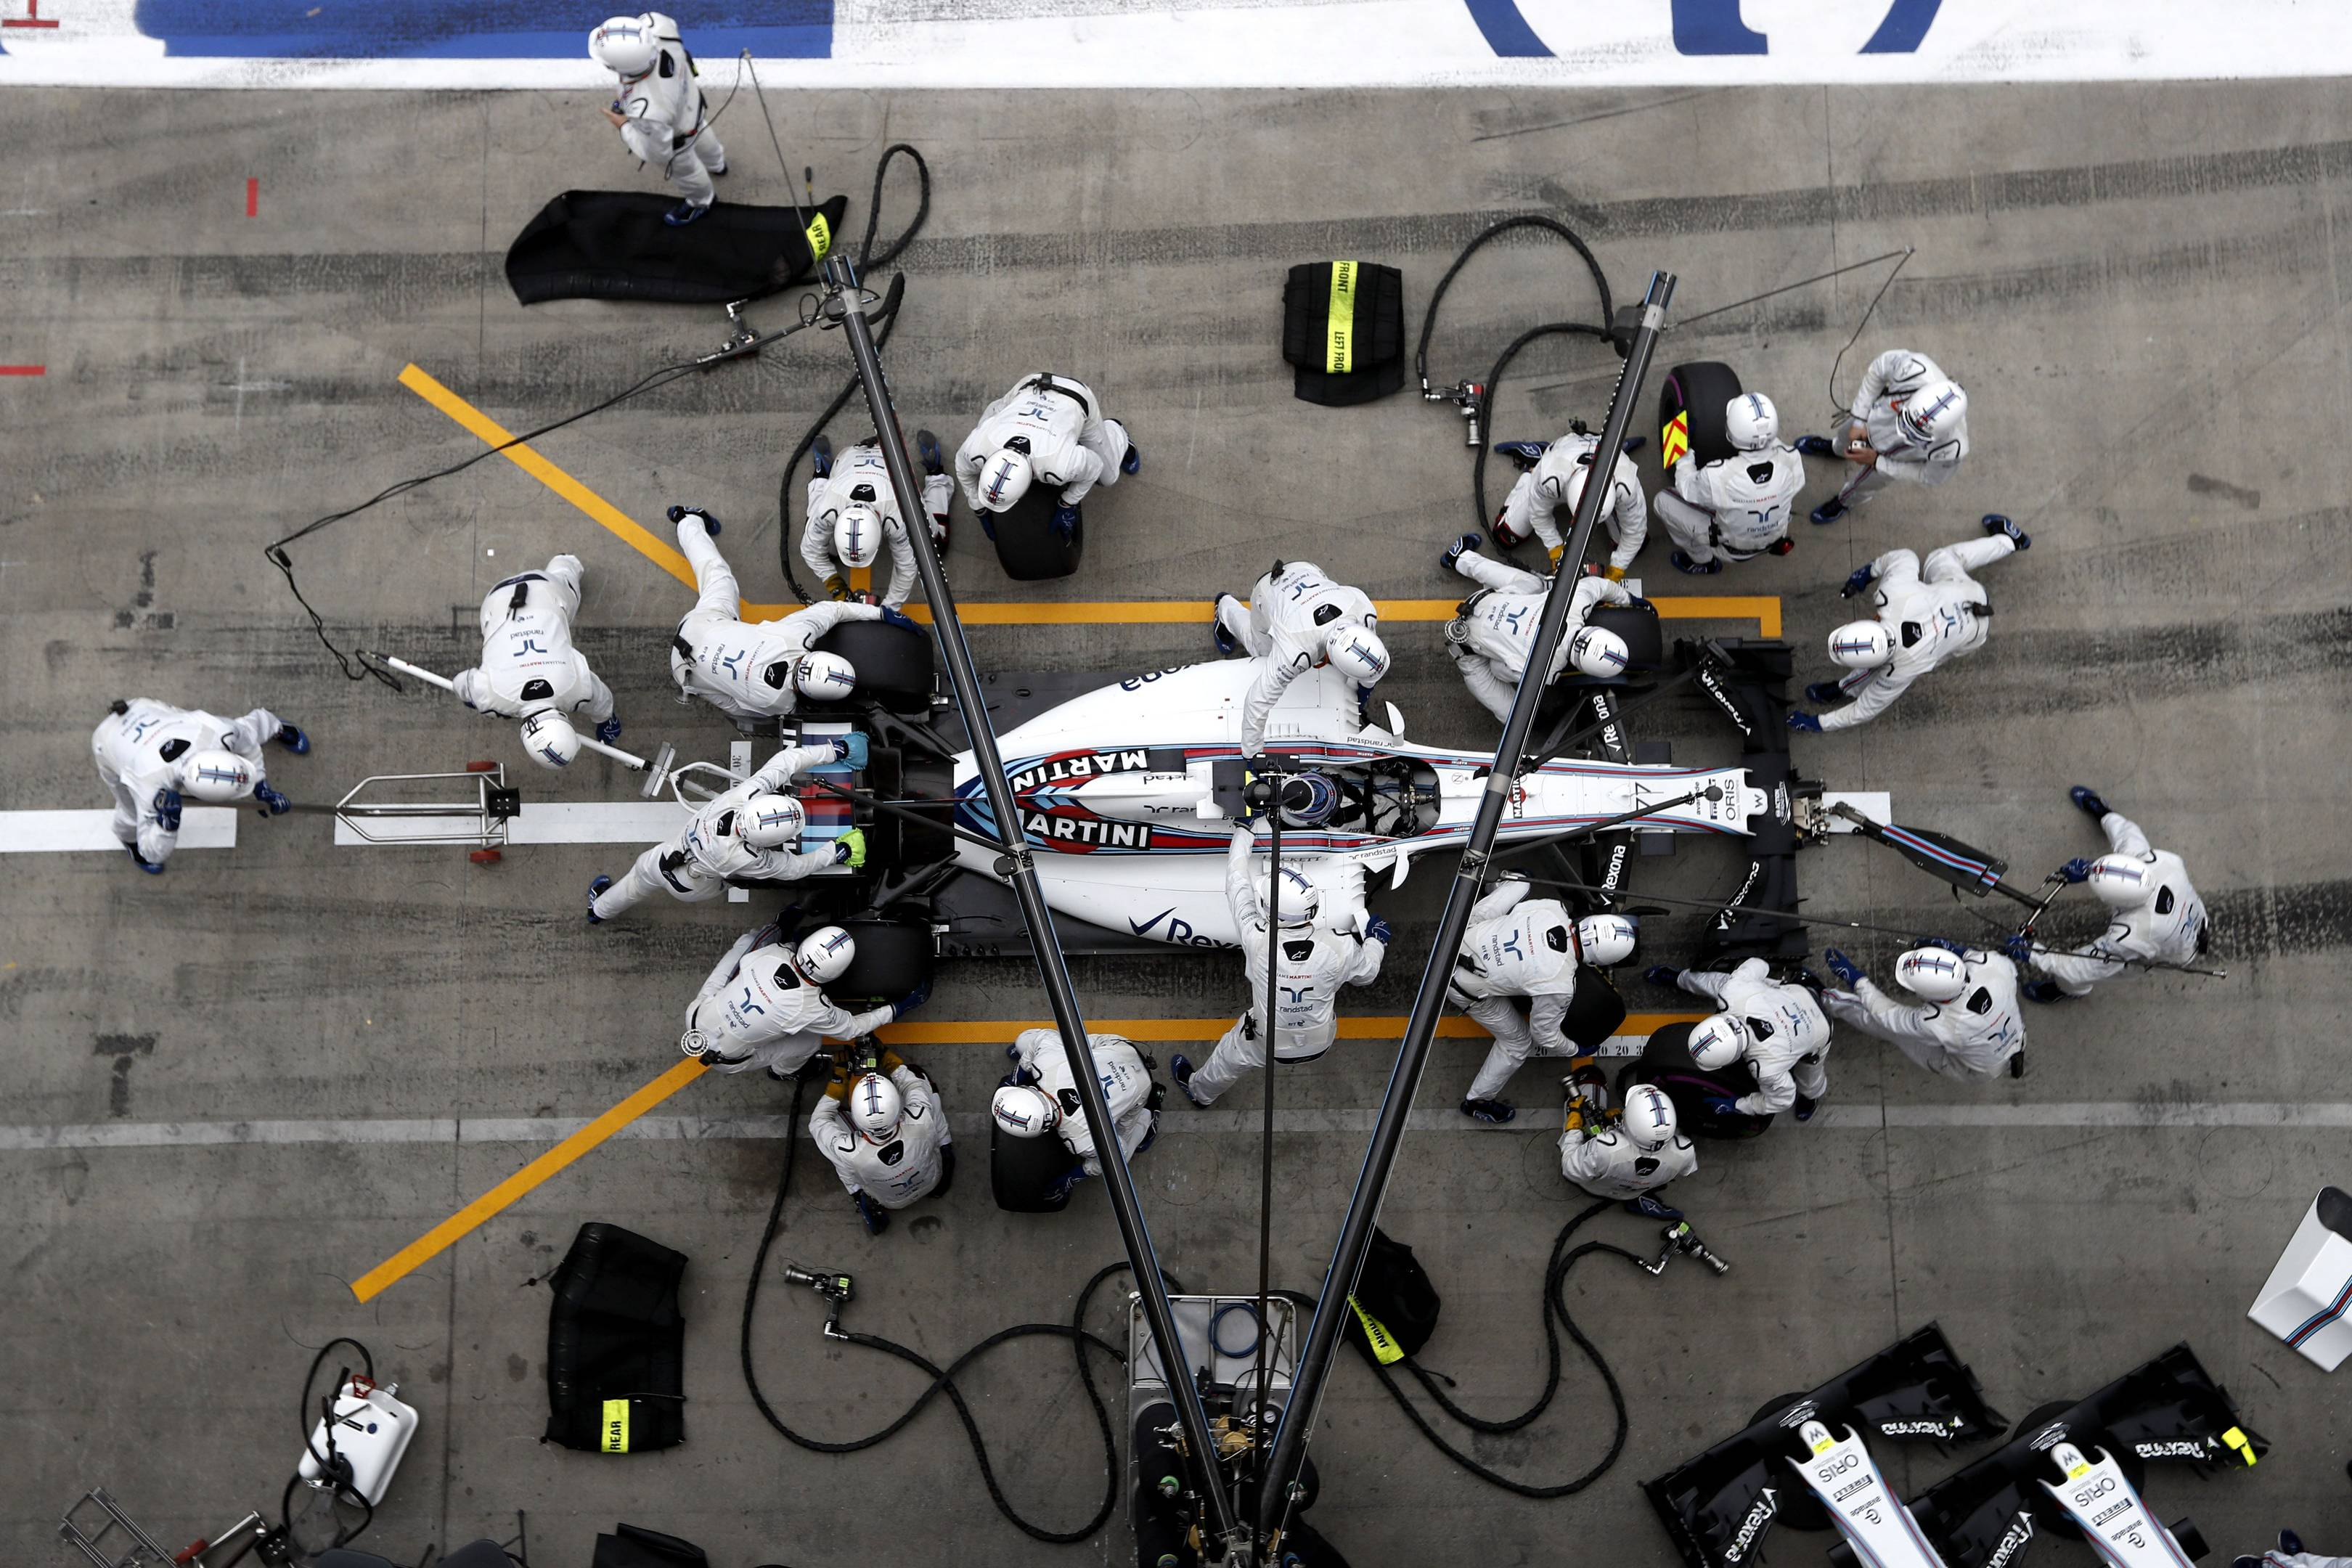

In [ ]:
racesWithPitInformation = races
racesWithoutPitInformation = races.iloc[0:0]
j=0
# for index, row in races.iterrows():
#     if pitStops[pitStops['raceId'] == index].empty:
#         racesWithPitInformation = racesWithPitInformation.drop(index)
#         racesWithoutPitInformation = racesWithoutPitInformation.append(row)

Préparation des sets : on va avoir un training set d'environ beaucoup d'exemples. On peut essayer d'appliquer la technique de cross-validation pour entraîner le modèle. <br>
Quelles sont les features ? 
<ul>
    <li>driverId</li>
    <li>circuitId</li>
    <li>lap</li>
    <li>milliseconds</li>
</ul>
Le label est un vecteur y de taille $m = nbLaps$.
Si le pilote a réalisé un pit-stop aux tours 4 et 8, on aura $y=[0,0,0,1,0,0,0,1,0,...,0]$

In [ ]:
# display(racesWithPitInformation.head())
# display(lapTimes.head())

datasetPit = lapTimes.merge(racesWithPitInformation, on='raceId')
datasetPit = datasetPit[['raceId','driverId','lap','milliseconds','circuitId']]
datasetPit = datasetPit[datasetPit['lap'] > 5]
# for index,row in datasetPit.iterrows():
#     if not pitStops[(pitStops['driverId'] == row['driverId']) & (pitStops['raceId'] == row['raceId']) & (pitStops['lap'] == row['lap'])].empty:
#         print(index)
#         datasetPit['pit'].iloc[index] = 1
display(datasetPit.head(10))

In [ ]:
my_dataset = pd.read_csv('dataset_pit.csv', index_col=0)
my_dataset = my_dataset[my_dataset['lap'] > 5]
my_dataset['previousLap'] = np.zeros(my_dataset.shape[0])
my_dataset_trans = my_dataset.shift(1)
my_dataset_trans.iloc[0] = my_dataset.iloc[0]
my_dataset['previousLap'] = my_dataset_trans['milliseconds']
my_dataset['previousLapRaceId'] = my_dataset_trans['raceId']
my_dataset['previousLapDriverId'] = my_dataset_trans['driverId']
my_dataset['previousLapPit'] = my_dataset_trans['pit']
my_dataset['previousLapDelta'] = np.where((my_dataset['raceId'] == my_dataset['previousLapRaceId']) & (my_dataset['driverId'] == my_dataset['previousLapDriverId']) & my_dataset['previousLapPit'] != 1, my_dataset['milliseconds']/my_dataset['previousLap'], 1)

my_dataset_fwd = my_dataset.shift(-1)
my_dataset_fwd.loc[my_dataset_fwd.shape[0]] =  my_dataset.loc[my_dataset.shape[0]]
my_dataset['nextLap'] = my_dataset_fwd['milliseconds']
my_dataset['nextLapRaceId'] = my_dataset_fwd['raceId']
my_dataset['nextLapDriverId'] = my_dataset_fwd['driverId']
my_dataset['nextLapPit'] = my_dataset_fwd['pit']
my_dataset['nextLapDelta'] = np.where((my_dataset['raceId'] == my_dataset['nextLapRaceId']) & (my_dataset['driverId'] == my_dataset['nextLapDriverId']) & my_dataset['nextLapPit'] != 1, (my_dataset['milliseconds']/my_dataset['nextLap']), 1)

my_dataset['lapDelta'] = (my_dataset['previousLapDelta']+my_dataset['nextLapDelta'])/2
my_dataset['lapDelta'] = my_dataset['lapDelta'].apply(lambda x: 10.0*(1-np.exp(1-x)))
# my_dataset['lapDelta'] = (my_dataset['lapDelta']-my_dataset['lapDelta'].mean())/my_dataset['lapDelta'].std()
my_dataset['lapDelta'] = np.where((np.abs(my_dataset['lapDelta']) < 0.05) | (my_dataset['pit'] == 0),0,10*my_dataset['lapDelta'])
my_dataset = my_dataset.drop(['previousLap','previousLapRaceId','previousLapDriverId','nextLap','nextLapRaceId','nextLapDriverId'],axis=1)
for i in range(1,50):
    my_dataset = my_dataset.drop(my_dataset['previousLapDelta'].idxmax())
    my_dataset = my_dataset.drop(my_dataset['nextLapDelta'].idxmax())
display(my_dataset.head(10))

On peut transformer le problème en un problème de régression logistique : <b>A un tour donné, quelle est la probablilité qu'un pilote réalise un arrêt au stand ?

On peut remarquer ici que seuls 4% des labels représentent un arrêt au stand : les données ne sont pas du tout équitablement réparties !!

In [ ]:
neg, pos = np.bincount(my_dataset['pit'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

On crée les ensembles d'entraînement, de validation et de test.

In [ ]:
cleaned_df = my_dataset[['lapDelta','pit']]
cleaned_df = cleaned_df.dropna()
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('pit'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('pit'))
test_labels = np.array(test_df.pop('pit'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)


# print('Training labels shape:', train_labels.shape)
# print('Validation labels shape:', val_labels.shape)
# print('Test labels shape:', test_labels.shape)

# print('Training features shape:', train_features.shape)
# print('Validation features shape:', val_features.shape)
# print('Test features shape:', test_features.shape)

pit_y = cleaned_df[cleaned_df['pit'] == 1]
pit_n = cleaned_df[cleaned_df['pit'] == 0]
neg = pit_n["pit"].count()
pos = pit_y['pit'].count()
total = neg+pos
display(pit_y.describe())
display(pit_n.describe())
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1.0 / neg)*(total)/2.0 
weight_for_1 = (1.0 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [ ]:
def sigmoid(x):
    return 1.0/(1+np.exp(-x))

def propagate(w, b, X, Y):
    m = X.shape[1]
    A = sigmoid(np.dot(w.T, X)+b)
#     print(np.log(A))
#     print(np.log(1-A))
    cost = (-1.0/m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))
    print('{}\r'.format(cost)),
    dw = (1.0/m)*np.dot(X,(A-Y).T)
    db = (1.0/m)*np.sum(A-Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []
    for i in range(num_iterations):
        grads, cost = propagate(w,b,X,Y)
        dw = grads["dw"]
        db = grads["db"]
        w = w - learning_rate*dw
        b = b - learning_rate*db
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        if A[0][i] > 0.5:
            Y_prediction[0][i] = 1
        else:
            Y_prediction[0][i] = 0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    w, b = np.zeros((X_train.shape[0],1)),0
    parameters, grads, costs = optimize(w,b,X_train,Y_train,num_iterations=num_iterations,learning_rate=learning_rate,print_cost=print_cost)
    w = parameters["w"]
    b = parameters["b"]
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [ ]:
train = train_features
lab = train_labels
test = test_features
test_lab = test_labels
print(train.shape)
print(lab.shape)
print(test.shape)
print(test_lab.shape)
d = model(train_features.T, train_labels, test_features.T, test_labels, num_iterations = 2000, learning_rate = 0.05, print_cost = False)

In [ ]:
costH = d['costs']
predictions = d['Y_prediction_test']
test_labels = np.transpose(test_labels)
test_labels = test_labels.reshape(1,28667)
# print(predictions.tolist())
print(predictions)
print(test_labels.shape)

In [ ]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Vrai label')
    plt.xlabel('Label predit')

plot_cm(test_labels[0], predictions[0])

In [ ]:
my_test = np.where(my_test <= 0.5,0,1)
cm = confusion_matrix(test_labels[0], predictions[0] > 0.5)
TP = cm[1][1]
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
precision = 1.0*TP/(TP+FP)
recall = 1.0*TP/(TP+FN)
accuracy = (1.0*TP+TN)/(TP+TN+FP+FN)
f1 = 2.0*(1.0*precision*recall)/(1.0*precision - recall)
tfp = 1.0*FP/(1.0*FP+TN)
print(f1)

In [ ]:
plt.plot(costH)
plt.suptitle('Evolution du cout en fonction des iterations')

En observant la matrice de confusion, on voit que l'algorithme prodigue un très grand nombre de VN (vrais négatifs) et un nombre raisonnable de VP (vrais positifs), alors qu'il n'a pas une seule fois prédit un pit-stop alors qu'il n'y en avait pas. 

<b>Nous avons réussi à déterminer si un pilote effectue un pit-stop !</b>

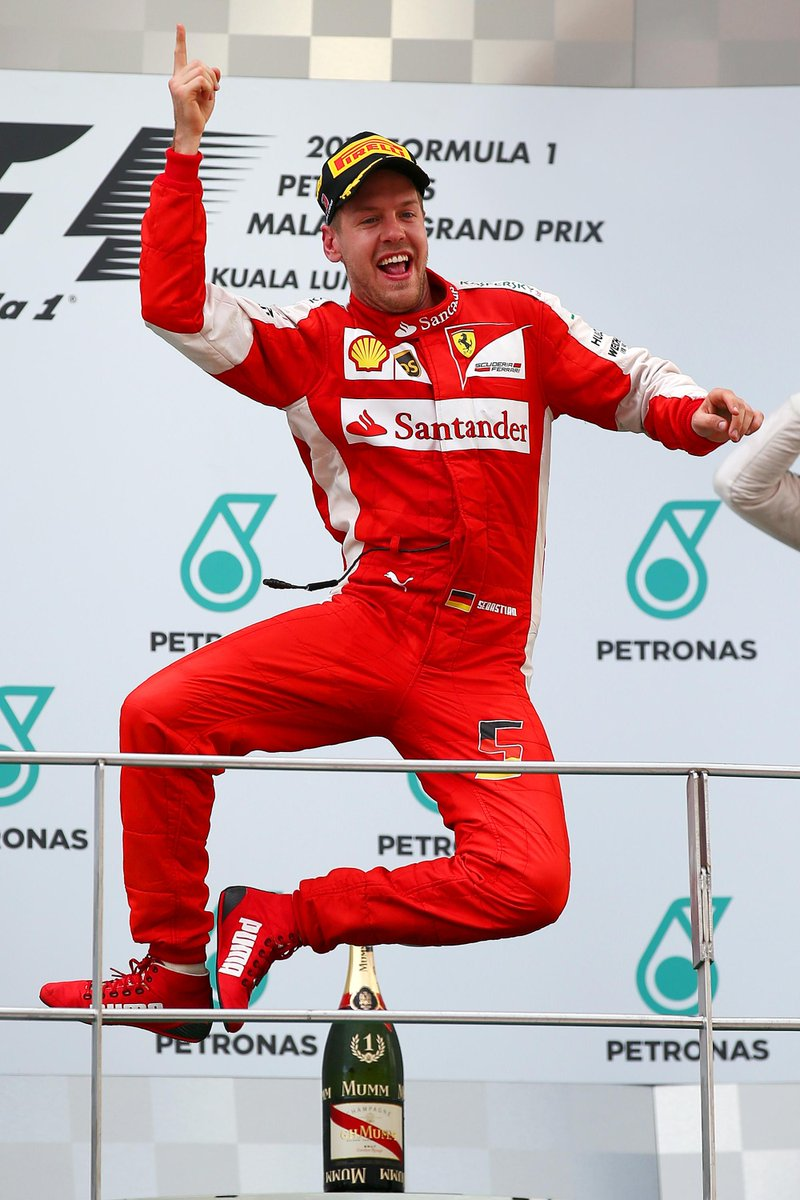

## Création d'un classificateur pour déterminer le type de pneu utilisé pendant un relais
En Formule 1, cinq types de pneus peuvent être utilisés pendant une course : 
<ul>
    <li> Soft : ce pneu, extrêmement rapide, possède la durée de vie la plus courte.</li>
    <li> Medium : ce pneu est moyennement rapide et possède une durée de vie moyenne.</li>
    <li> Hard : ce pneu est le plus lent mais le plus durable.</li>
    <li> Inter : ce pneu est conçu pour être utilisé sur circuit humide.</li>
    <li> Wet : ce pneu est utilisé dans le cas d'un circuit trempé, c'est le plus lent de tous.</li>
</ul>
L'objectif de ce classificateur est de pouvoir déterminer le type de pneu utilisé pendant un relais (période de roulage entre deux arrêts au stand).
Il s'agit d'un problème <b>d'apprentissage non supervisé</b> car nous n'avons pas de labels à notre disposition pour entraîner le modèle.

<a href="https://f1metrics.wordpress.com/2014/06/04/who-was-the-best-wet-weather-driver/#bottom">Ce lien recense toutes les courses de Formule 1 qui se sont déroulées sous la pluie</a><br>
Il est possible d'utiliser ces données pour classifier : en effet, si une course ne s'est pas déroulée par temps pluvieux, alors on peut disqualifier d'office les pneux <i>Inter</i> et <i>Wet</i>.

In [ ]:
def getStints(raceId,driverId):
    (race,driver,result,pits,quali,laps) = getInformation(raceId, driverId)
    print(str(race['year'])+ ' '+str(race['name'])+'\n')
    display(pits)
    display(laps.head())
    #myStops est un tableau contenant les numéros de tour auxquels le pilote a effectué un arrêt au stand. 
    #raceDuration = results.loc[(results['raceId'] == raceId) & (results['driverId'] == driverId)]['laps'].iloc[0]
    #raceDuration est le nombre de tours parcouru par le pilote.
    laps = lapTimes.loc[(lapTimes['raceId'] == raceId) & (lapTimes['driverId'] == driverId)]
    j=0
    raceDuration = laps.shape[0]
    for i in range(1,raceDuration+1):
        print('Tour '+str(i)+' : '+laps['time'].iloc[i-1])
        if j < pits.shape[0] and i == pits['lap'].iloc[j]:
            print("Arrêt au stand au tour "+str(pits['lap'].iloc[j])+' : '+pits['duration'].iloc[j])
            j+=1
    laps['milliseconds'].plot()
    #return stopsLaps 
    